In [1]:
import numpy as np
from pylab import *
from astropy.cosmology import FlatLambdaCDM

%matplotlib inline

In [2]:
##### LCDM parameters
h=0.6774
Om0 = 0.309
H0=h*100

cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

In [3]:
### simulation configuration
box_size_Mpch=5000
box_size= box_size_Mpch/h ## Mpc
Npart = 8192 #2**13

### box resolution
res_box = (Npart/box_size)**3 ## particle/(Mpc/h)^3
print (res_box, 'particle/Mpc^3 resolution')
print ('box size: %s (Mpc); %s (Mpc/h)' %(box_size, box_size_Mpch))

### total particles, without subsample
Npart_tot = cosmo.comoving_volume(4.0).value*res_box
print (Npart_tot/1e12, 'x 10^12 particles;', Npart_tot/(Npart**3), 'x box size')

1.367084611787465 particle/Mpc^3 resolution
box size: 7381.163271331562 (Mpc); 5000 (Mpc/h)
2.264953006467051 x 10^12 particles; 4.119925518292896 x box size


In [4]:
#### survey requirement; 
ell_lim = 2000 
ell_plus = 5000 ## ideal 

#### conversion from fourier space to real space: ell=pi/theta
## real space resolution, in unit of radian
theta_lim_rad = pi/ell_lim
theta_plus_rad = pi/ell_plus

## unit of arcmin
theta_lim_arcmin=degrees(theta_lim_rad)*60
theta_plus_arcmin=degrees(theta_plus_rad)*60

print (theta_lim_arcmin, 'arcmin (basic),', theta_plus_arcmin,'arcmin (ideal)',)

5.4 arcmin (basic), 2.1599999999999997 arcmin (ideal)


In [5]:
### redshift array of density shells
zarr = np.linspace(0.1, 4, 100)

### volumne of each density shell 
vol=cosmo.comoving_volume(zarr).value ## Mpc^3
vol_diff = vol.copy() 
vol_diff[1:]=vol[1:]-vol[:-1]
# print (vol_diff) ## this is the volume in each density shell

In [6]:
### compute from angular scale to physical scale
kpc_per_arcmin = cosmo.kpc_comoving_per_arcmin(zarr).value
Mpc_res_lim = kpc_per_arcmin*theta_lim_arcmin/1e3
Mpc_res_plus = kpc_per_arcmin*theta_plus_arcmin/1e3

res_lim = (1/Mpc_res_lim)**3
res_plus = (1/Mpc_res_plus)**3

In [7]:
H0=h*100
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

zlim=4.0
zarr = np.linspace(0.1, zlim, 100)

kpc_per_arcmin = cosmo.kpc_comoving_per_arcmin(zarr).value
vol=cosmo.comoving_volume(zarr).value ## Mpc^3
vol_diff = vol.copy() 
vol_diff[1:]=vol[1:]-vol[:-1]

    
def calc_storage(ell_lim, storage_only=True, box_size_Mpch=5000, Npart = 8192):
    '''from ell_lim, return:
    (1) the subsample rate at each redshift 
    (2) ratio of subsample storage/total storage
    currently works with specific cosmology
    '''
    
    theta_lim_rad = pi/ell_lim
    theta_lim_arcmin=degrees(theta_lim_rad)*60
    
    #### turn this one if want different cosmology
    # H0=h*100
    # cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    # kpc_per_arcmin = cosmo.kpc_comoving_per_arcmin(zarr).value
    ### volumne of each density shell 
    vol=cosmo.comoving_volume(zarr).value ## Mpc^3
    vol_diff = vol.copy() 
    vol_diff[1:]=vol[1:]-vol[:-1]
    
    Mpc_res_lim = kpc_per_arcmin*theta_lim_arcmin/1e3
    res_lim = (1/Mpc_res_lim)**3

    box_size= box_size_Mpch/h ## Mpc
    res_box = (Npart/box_size)**3 ## particle/(Mpc/h)^3
    Npart_tot = cosmo.comoving_volume(zlim).value*res_box

    rate_sub = res_lim/res_box
    rate_sub[rate_sub>1]=1 ### for low redshift, no subsample
    Npart_sub = sum(vol_diff * res_box * rate_sub)
    if storage_only:
        return Npart_sub/Npart_tot
    else:
        return array([zarr, rate_sub]), Npart_sub/Npart_tot

In [8]:
ell_arr = arange(2000,10000)
storage_rate = array(list(map(calc_storage, ell_arr)))

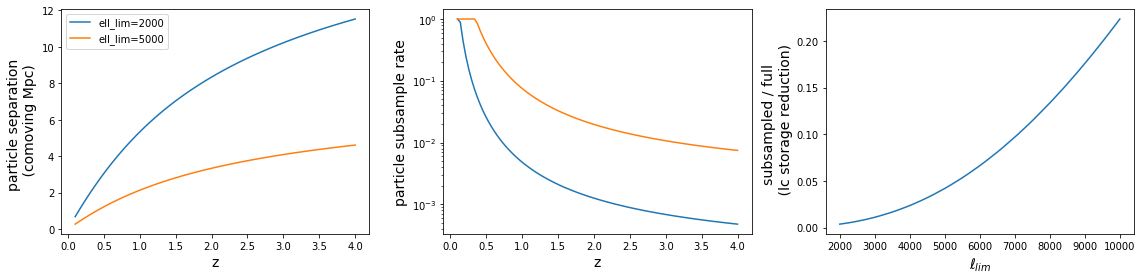

In [9]:
ifs=14
f, ax = subplots (1,3,figsize=(16,4))

####### physical size vs ell
ax[0].plot(zarr, Mpc_res_lim,label='ell_lim=%s'%(ell_lim))
ax[0].plot(zarr, Mpc_res_plus,label='ell_lim=%s'%(ell_plus))
ax[0].set_ylabel('particle separation \n (comoving Mpc)', fontsize=ifs)
ax[0].set_xlabel('z', fontsize=ifs)
ax[0].legend()

####### sub sample rate
for ell_lim in [2000,5000]:
    zarr, rate_sub = calc_storage(ell_lim, storage_only=False)[0]
    ax[1].plot(zarr, rate_sub, label='ell_lim=%i'%(ell_lim))
# ax[1].plot(zarr, res_plus/res_box)
ax[1].set_yscale('log')
ax[1].set_xlabel('z', fontsize=ifs)
ax[1].set_ylabel('particle subsample rate', fontsize=ifs)

####### total storage vs ell_lim
ax[2].plot(ell_arr, storage_rate)
ax[2].set_xlabel(r'$\ell_{lim}$', fontsize=ifs)
ax[2].set_ylabel('subsampled / full \n (lc storage reduction)', fontsize=ifs)

plt.tight_layout()

show()

In [10]:
calc_storage(1e5)

1.0